<a href="https://colab.research.google.com/github/delemarchand2020/ExtractDataFromImageDoc/blob/main/PoC_extraction_avec_VLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extraction avec Microsoft Phi3 Vision Language model
* https://medium.com/@enrico.randellini/exploring-microsoft-phi3-vision-language-model-as-ocr-for-document-data-extraction-c269f7694d62
* https://huggingface.co/microsoft/Phi-3-vision-128k-instruct
* https://ritvik19.medium.com/papers-explained-130-phi-3-0dfc951dc404
* https://medium.com/@mauryaanoop3/unleashing-structured-responses-functional-calling-with-langchain-ollama-and-phi-3-part-3-720b34203778

Pour utiliser un modèle Phi3 Vision depuis Azure:
* https://github.com/Azure/azureml-examples/blob/main/sdk/python/foundation-models/phi-3/litellm.ipynb

Pour le fine-tuning, voir cet exemple:
* https://github.com/2U1/Phi3-Vision-ft
* https://wandb.ai/byyoung3/mlnews3/reports/How-to-fine-tune-Phi-3-vision-on-a-custom-dataset--Vmlldzo4MTEzMTg3

##Installation des librairies

In [1]:
!pip install -q torch torchvision

In [2]:
!pip install -q pillow chardet flash_attn accelerate bitsandbytes Requests transformers

In [3]:
!pip install -q --upgrade 'nbconvert>=7' 'mistune>=2'

In [4]:
!pip install -q cchardet

##Chargement d'images de test

In [5]:
!wget https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/recu_masso_photo.png -O recu_masso_photo.png
!wget https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/billet_medecin.png -O billet_medecin.png
!wget https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/specheck1.png -O specheck1.png
!wget https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/specheck4.png -O specheck4.png
!wget https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/specheck16.png -O specheck16.png

--2024-06-23 21:53:59--  https://github.com/delemarchand2020/ExtractDataFromImageDoc/raw/main/recu_masso_photo.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/delemarchand2020/ExtractDataFromImageDoc/main/recu_masso_photo.png [following]
--2024-06-23 21:53:59--  https://raw.githubusercontent.com/delemarchand2020/ExtractDataFromImageDoc/main/recu_masso_photo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3541129 (3.4M) [image/png]
Saving to: ‘recu_masso_photo.png’

recu_masso_photo.pn 100%[===================>]   3.38M  --.-KB/s    in 0.05s   

2024-06-23 21:54:00 (68.6 MB/s) - ‘recu_mas

##Chargement du modèle

In [6]:
# Import necessary libraries
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch
from IPython.display import display
import time


# Define model ID
model_id = "microsoft/Phi-3-vision-128k-instruct"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Define BitsAndBytes configuration for 8-bit quantization
#nf8_config = BitsAndBytesConfig(
#    load_in_8bit=True,
#    bnb_8bit_quant_type="nf8",
#    bnb_8bit_use_double_quant=True,
#    bnb_8bit_compute_dtype=torch.bfloat16,
#)

# Load model with 4-bit or 8-bit quantization and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def model_inference(messages, path_image, disp=False):

    start_time = time.time()

    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=128,
        do_sample=False,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    if disp:
      display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

##Test d'extraction

In [8]:
# @title Extraction sur billet de médecin
prompt_billet_medecin = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields, do not invent data (keep field empty if you don't know) and put it in a JSON format: \
'Tel: tel number of the clinic', 'Date:', 'Name: name of the patient', 'Adress: address of the patient (could be empty)'"}]


# Download image from URL
path_image = "/content/billet_medecin.png"

# inference
model_inference(prompt_billet_medecin, path_image, disp=False)

Inference time: 8.042568922042847
{
"Tel": "514-938-0995",
"Date": "10-11-23",
"Name": "Geraldine V. Valli",
"Adress": "100 boulevard de Maisonneuve O. Montreal H4A 3T2"
}


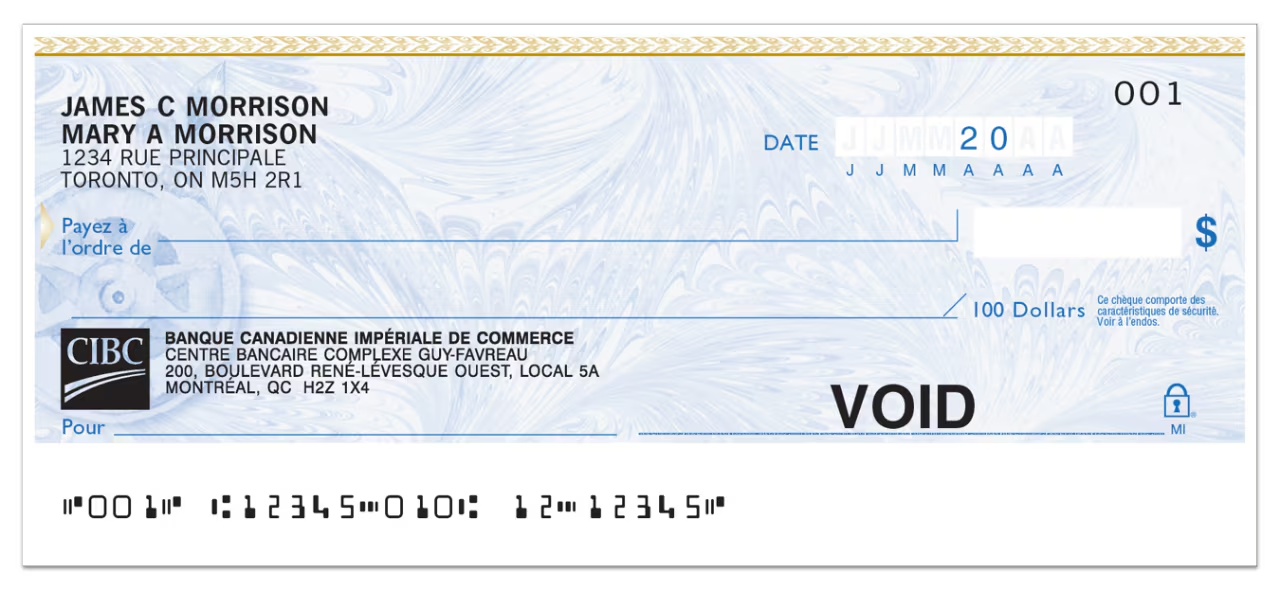

In [9]:
# @title Extraction sur void check
# @markdown Check specification : https://www.payments.ca/sites/default/files/standard006eng.pdf
prompt_check = [{"role": "user", "content": "<|image_1|>\nOCR the text of the check image. Extract the data of the following fields and put it in a JSON format: \
'Client Name', 'Bank name (in list of canadian bank)', 'MICR data'"}]

# Download image from URL
path_image = "/content/specheck1.png"

# inference
model_inference(prompt_check, path_image, disp=True)

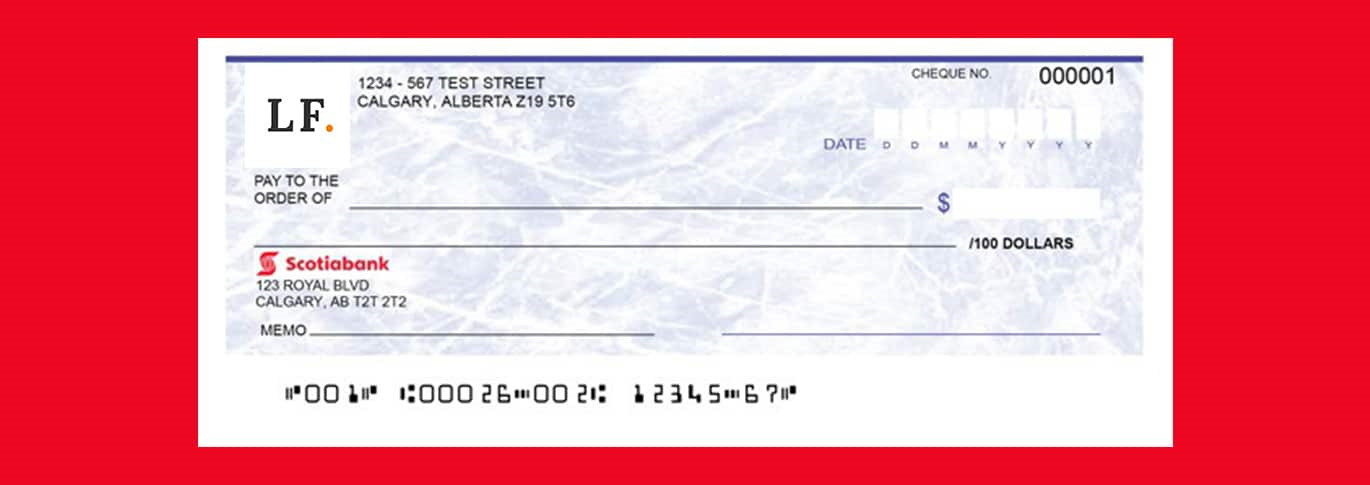

Inference time: 10.903365135192871
{'Client_Name': LINDA MORRISON,'Bank_Name': SCOTIABANK,'MICR_Data': 00 11 10 26 00 21 1234 5 67 71 20 10 26 00 21 1234 5 67 71 20 10 26 00 21 1234 5 67 71 20 10 26 00


In [40]:
# @title Extraction sur specimen check
prompt_check = [{"role": "user", "content": "<|image_1|>\nOCR the text of the check image. Extract the data of the following fields and put it in a JSON format: \
'Client Name', 'Bank name (in list of canadian bank)', ' MICR numbers (multi parts)'"}]

prompt_check = [{"role": "user", "content": "<|image_1|>\nExtract Client_Name, Bank_Name, MICR_Data in a JSON format"}]

# Download image from URL
path_image = "/content/specheck4.png"

# inference
model_inference(prompt_check, path_image, disp=True)

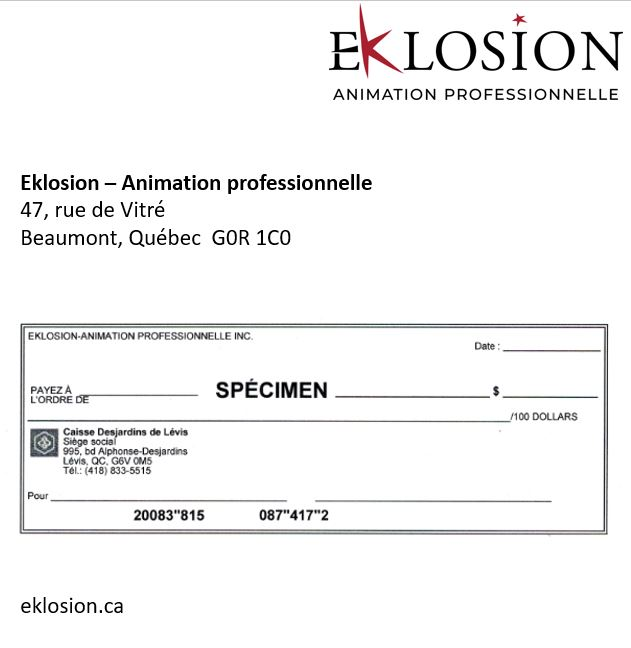

Inference time: 7.742731094360352
{
  "Client or enterprise name": "EKLOSION-ANIMATION PROFESSIONNELLE INC.",
  "Bank name (in list of canadian bank)": "Caisse Desjardins de Lévis",
  "MICR numbers (multi parts)": ["20083*815", "087*417*2"]
}


In [11]:
# @title Extraction sur spécimen chèque FR inclus dans une lettre
prompt_check = [{"role": "user", "content": "<|image_1|>\nOCR the text of the image. Extract the data of the following fields and put it in a JSON format: \
'Client or enterprise name', 'Bank name (in list of canadian bank)', ' MICR numbers (multi parts)'"}]

#prompt_check = [{"role": "user", "content": "<|image_1|>\nExtract Client_Name or Entreprise_Name, Bank_Name, MICR_Data in a JSON format"}]

# Download image from URL
path_image = "/content/specheck16.png"

# inference
model_inference(prompt_check, path_image, disp=True)

#Fine-tuning du modèle pour améliorer l'extraction des codes MICR des chèques

##Création de code MICR synthétique

###Chargement des images des caractères MICR

In [12]:
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0030.svg -O 0.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0031.svg -O 1.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0032.svg -O 2.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0033.svg -O 3.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0034.svg -O 4.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0035.svg -O 5.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0036.svg -O 6.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0037.svg -O 7.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0038.svg -O 8.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0039.svg -O 9.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u2446.svg -O A.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u2447.svg -O B.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u2448.svg -O C.svg
!wget https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u2449.svg -O D.svg

--2024-06-23 21:54:44--  https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0030.svg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343 [image/svg+xml]
Saving to: ‘0.svg’

0.svg               100%[===================>]     343  --.-KB/s    in 0s      

2024-06-23 21:54:44 (9.83 MB/s) - ‘0.svg’ saved [343/343]

--2024-06-23 21:54:44--  https://raw.githubusercontent.com/zaxbux/MICR_E13-B_Font/main/svgs/u0031.svg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328 [image/svg+xml]
Saving to: ‘1.svg’

1.svg           

###Installation des librairies pour le traitement des images

In [13]:
!pip -q install svgwrite cairosvg pillow

###Fonctions pour la création d'une image de ligne MICR

In [14]:
import os
from PIL import Image, ImageDraw
import cairosvg
from IPython.display import display

# Dictionnaire pour mapper les caractères MICR aux fichiers SVG correspondants
micr_map = {
    '0': '0.svg',
    '1': '1.svg',
    '2': '2.svg',
    '3': '3.svg',
    '4': '4.svg',
    '5': '5.svg',
    '6': '6.svg',
    '7': '7.svg',
    '8': '8.svg',
    '9': '9.svg',
    'A': 'A.svg',
    'B': 'B.svg',
    'C': 'C.svg',
    'D': 'D.svg'
    # Ajoutez les autres caractères MICR si nécessaire
}

# Fonction pour convertir un fichier SVG en PNG avec redimensionnement
def convert_svg_to_png(svg_file, png_file, scale_factor):
    # Lire le contenu du fichier SVG
    with open(svg_file, 'r') as file:
        svg_content = file.read()

    # Ajouter ou ajuster l'attribut viewBox pour redimensionner correctement le SVG
    if 'viewBox' not in svg_content:
        svg_content = svg_content.replace('<svg ', '<svg viewBox="0 0 100 100" ', 1)

    svg_content = svg_content.replace('<svg ', f'<svg width="{scale_factor}" height="{scale_factor}" ', 1)

    # Convertir le fichier SVG redimensionné en PNG
    cairosvg.svg2png(bytestring=svg_content.encode('utf-8'), write_to=png_file)

# Fonction pour charger les images PNG et les stocker dans un dictionnaire
def load_micr_images(svg_folder, micr_map, font_size, border_size):
    micr_images = {}
    for char, svg_file in micr_map.items():
        svg_path = os.path.join(svg_folder, svg_file)
        png_path = svg_path.replace('.svg', '.png')
        convert_svg_to_png(svg_path, png_path, font_size)
        img = Image.open(png_path)

        # Ajouter une bordure transparente autour de chaque image
        new_size = (img.width + 2 * border_size, img.height + 2 * border_size)
        new_img = Image.new('RGBA', new_size, (0, 0, 0, 0))
        new_img.paste(img, (border_size, border_size))

        micr_images[char] = new_img
    return micr_images

# Fonction pour générer une image MICR
def generate_micr_image(code, font_size=1.0, svg_folder='./', spacing_factor=0.8, border_size=10):
    # Charger les images MICR avec la taille de police spécifiée et une bordure
    micr_images = load_micr_images(svg_folder, micr_map, font_size, border_size)

    # Vérifier que tous les caractères du code sont valides
    for char in code:
        if char != ' ' and char not in micr_images:
            raise ValueError(f"Caractère MICR non valide: {char}")

    # Charger les images PNG correspondant aux caractères du code
    images = [micr_images[char] if char != ' ' else None for char in code]

    # Calculer la largeur d'un espace (taille d'un caractère MICR * spacing_factor)
    space_width = int(list(micr_images.values())[0].width * spacing_factor)

    # Calculer la largeur totale de l'image finale en ajoutant les espaces
    total_width = 0
    for img in images:
        if img is not None:
            total_width += img.width + space_width
        else:
            total_width += space_width

    max_height = max(img.height if img is not None else 0 for img in images)

    # Créer une nouvelle image transparente avec mode 'RGBA'
    micr_image = Image.new('RGBA', (total_width, max_height), (0, 0, 0, 0))

    # Coller les images PNG dans l'image finale avec un espace entre chaque caractère
    x_offset = 0
    for img in images:
        if img is not None:
            y_offset = (max_height - img.height) // 2
            micr_image.paste(img, (x_offset, y_offset), img)
            x_offset += img.width
        x_offset += space_width

    # Retourner l'image finale
    return micr_image

####Test génération image MICR

In [15]:
# Exemple d'utilisation
micr_image = generate_micr_image('C001C A00026D002A 12345D67C', font_size=12.5, svg_folder='./', spacing_factor=0.5, border_size=1)

# Afficher l'image
display(micr_image)

###Fonction pour créer un MICR canadien

In [16]:
# Fonction pour générer un code MICR canadien
def generate_canadian_micr_code(serial_number, account_number, ctrl, transit_number, institution_number, font_size=12.5, svg_folder='./', spacing_factor=0.5, border_size=0):
    # Formater le code MICR canadien
    micr_code = f'C{serial_number}C A{transit_number}D{institution_number}A {account_number}D{ctrl}C'

    # Générer l'image MICR
    return generate_micr_image(micr_code, font_size, svg_folder, spacing_factor, border_size)

In [17]:
#Exemple d'utilisation
canadian_micr_image = generate_canadian_micr_code(serial_number= '001',account_number='12345', ctrl='67', transit_number='00026', institution_number='002')

# Afficher l'image
display(canadian_micr_image)

In [18]:
#Exemple d'utilisation
canadian_micr_image = generate_canadian_micr_code(serial_number= '001',account_number='123456', ctrl='55', transit_number='30303', institution_number='815')

# Afficher l'image
display(canadian_micr_image)

##Création de chèque factice

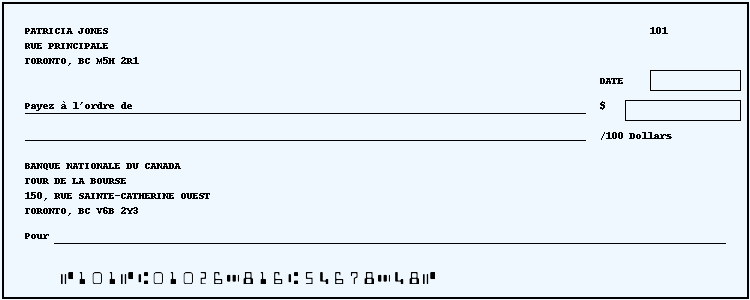

101 01026 816 54678 48


In [19]:
import os
from PIL import Image, ImageDraw, ImageFont
import cairosvg
from IPython.display import display

# Liste de couleurs claires
light_colors = [
    (255, 255, 255),  # Blanc
    (240, 248, 255),  # Azure
    (255, 255, 224),  # Jaune clair
    (240, 255, 240),  # Honeydew
    (255, 239, 213),  # PapayaWhip
    (245, 245, 220),  # Beige
    (250, 250, 210),  # Light Goldenrod Yellow
    (255, 250, 240),  # Floral White
    (248, 248, 255)   # Ghost White
]

import random

# Listes de prénoms, noms, rues, villes, provinces et codes postaux pour le client et la banque
first_names = ["JAMES", "MARY", "ROBERT", "PATRICIA", "MICHAEL", "LINDA"]
last_names = ["MORRISON", "SMITH", "JOHNSON", "BROWN", "WILLIAMS", "JONES"]
streets = ["RUE PRINCIPALE", "AVENUE DES CHAMPS", "BOULEVARD SAINT-LAURENT", "RUE SAINTE-CATHERINE"]
cities = ["TORONTO", "MONTREAL", "VANCOUVER", "CALGARY", "OTTAWA", "QUEBEC"]
provinces = ["ON", "QC", "BC", "AB", "MB", "NS"]
postal_codes = ["M5H 2R1", "H2Z 1X4", "V6B 2Y3", "T2P 2B5", "K1A 0B1", "G1R 3Y8"]

bank_names = [
    "BANQUE CANADIENNE IMPERIALE DE COMMERCE",
    "BANQUE NATIONALE DU CANADA",
    "BANQUE ROYALE DU CANADA",
    "BANQUE DE MONTREAL",
    "CAISSE DESJARDINS DU COMPLEXE"
]
bank_addresses = [
    "CENTRE BANCAIRE COMPLEXE GUY-FAVREAU",
    "TOUR DE LA BOURSE",
    "PLACE VILLE MARIE",
    "CENTRE DES AFFAIRES",
    "COMPLEXE DESJARDINS"
]
bank_streets = [
    "200, BOULEVARD RENE-LEVESQUE OUEST, LOCAL 5A",
    "800, RUE DE LA GAUCHETIERE OUEST",
    "1, PLACE VILLE MARIE",
    "129, RUE SAINT-JACQUES",
    "150, RUE SAINTE-CATHERINE OUEST"
]
bank_cities = ["MONTREAL", "TORONTO", "VANCOUVER", "QUEBEC"]
bank_provinces = ["QC", "ON", "BC", "QC"]
bank_postal_codes = ["H2Z 1X4", "M5H 2R1", "V6B 2Y3", "G1R 3Y8"]


# Fonction pour créer un chèque factice inspiré de l'image fournie
def create_fake_cheque(serial_number, account_number, ctrl, transit_number, institution_number, client_address=None, bank_info=None, font_size=10.5, svg_folder='./', spacing_factor=0.8, border_size=10, bk_color=None):
    # Créer une image de fond pour le chèque
    cheque_width = 750
    cheque_height = 300

    # Si bk_color est None, choisir aléatoirement une couleur claire
    if bk_color is None:
      bk_color = random.choice(light_colors)
    cheque_image = Image.new('RGB', (cheque_width, cheque_height), bk_color)  # Fond gris
    draw = ImageDraw.Draw(cheque_image)

    if client_address is None:
      # Générer des coordonnées aléatoires pour le client
      client_first_name = random.choice(first_names)
      client_last_name = random.choice(last_names)
      client_street = random.choice(streets)
      client_city = random.choice(cities)
      client_province = random.choice(provinces)
      client_postal_code = random.choice(postal_codes)

      client_address = f"{client_first_name} {client_last_name}\n{client_street}\n{client_city}, {client_province} {client_postal_code}"

    if bank_info is None:
      # Générer des coordonnées aléatoires pour la banque
      bank_name = random.choice(bank_names)
      bank_address = random.choice(bank_addresses)
      bank_street = random.choice(bank_streets)
      bank_city = random.choice(bank_cities)
      bank_province = random.choice(bank_provinces)
      bank_postal_code = random.choice(bank_postal_codes)

      bank_info = f"{bank_name}\n{bank_address}\n{bank_street}\n{bank_city}, {bank_province} {bank_postal_code}"

    # Ajouter les coordonnées du client
    font = ImageFont.load_default()  # Utiliser une police par défaut pour l'exemple
    draw.text((25, 25), client_address, fill="black", font=font)

    # Ajouter le numéro de chèque
    draw.text((650, 25), f"{serial_number}", fill="black", font=font)

    # Ajouter la date encadrée
    draw.text((600, 75), f"DATE", fill="black", font=font)
    draw.rectangle([(650, 70), (740, 90)], outline="black", width=1)

    # Ajouter les lignes de payee et montant
    payee_text = "Payez à l'ordre de"
    draw.text((25, 100), payee_text, fill="black", font=font)
    payee_text_bbox = draw.textbbox((25, 100), payee_text, font=font)
    draw.line([(25, payee_text_bbox[3] + 2), (585, payee_text_bbox[3] + 2)], fill="black", width=1)  # Aligner sur le bas du texte

    # Ajouter la seconde ligne pour le montant en mots
    draw.line([(25, 140), (585, 140)], fill="black", width=1)

    # Encadré pour le montant
    draw.text((600, 100), "$", fill="black", font=font)
    draw.rectangle([(625, 100), (740, 120)], outline="black", width=1)

    # Aligner le texte "/100 Dollars" avec la ligne du montant en mots
    draw.text((600, 160 - 30), "/100 Dollars", fill="black", font=font)  # Ajuster 140 pour l'aligner avec la ligne

    # Ajouter les informations bancaires
    draw.text((25, 160), bank_info, fill="black", font=font)

    # Ajouter la ligne de mémo
    memo_text = "Pour"
    draw.text((25, 230), memo_text, fill="black", font=font)
    memo_text_bbox = draw.textbbox((25, 230), memo_text, font=font)
    draw.line([(memo_text_bbox[2] + 5, memo_text_bbox[3] + 2), (725, memo_text_bbox[3] + 2)], fill="black", width=1)  # Aligner sur le bas du texte

    # Ajouter un cadre autour du rectangle du chèque
    frame_width = 2  # Largeur du cadre plus fine
    draw.rectangle([(frame_width, frame_width), (cheque_width - frame_width, cheque_height - frame_width)], outline="black", width=frame_width)

    # Générer l'image MICR
    micr_code = f'{serial_number} {transit_number} {institution_number} {account_number} {ctrl}'

    micr_image = generate_canadian_micr_code(serial_number, account_number, ctrl, transit_number, institution_number, font_size, svg_folder, spacing_factor, border_size)

    # Calculer la position pour coller l'image MICR au plus bas possible et alignée à gauche
    micr_x_base = 25
    micr_x = micr_x_base + random.randint(0, 175)
    micr_y = cheque_height - micr_image.height - 15  # Ajuster cette valeur pour que la ligne MICR soit au plus bas

    # Coller l'image MICR sur le chèque
    cheque_image.paste(micr_image, (micr_x, micr_y), micr_image)

    return cheque_image, micr_code, client_address, bank_info

# Coordonnées du client et de la banque
client_address = "JAMES C MORRISON\nMARY A MORRISON\n1234 RUE PRINCIPALE\nTORONTO, ON M5H 2R1"
bank_info = "BANQUE CANADIENNE IMPERIALE DE COMMERCE\nCENTRE BANCAIRE COMPLEXE GUY-FAVREAU\n200, BOULEVARD RENE-LEVESQUE OUEST, LOCAL 5A\nMONTREAL, QC  H2Z 1X4"

# Exemple d'utilisation
fake_cheque_image, micr_code, _, _ = create_fake_cheque('101', '54678', '48', '01026', '816',
                                                  client_address=None, bank_info=None, font_size=12.5, svg_folder='./',
                                                  spacing_factor=0.1, border_size=1, bk_color=None)

# Afficher l'image
display(fake_cheque_image)
print(micr_code)

##Création dataset chèques

In [31]:
import pandas as pd
import random
import os

# Fonction pour générer un dataset de N chèques
def generate_cheque_dataset(N, output_folder, svg_folder='./'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    data = []

    for i in range(N):
        serial_number = f"{i+1:06d}"
        account_number = f"{random.randint(100000, 999999)}"
        ctrl = f"{random.randint(10, 99)}"
        transit_number = f"{random.randint(10000, 99999)}"
        institution_number = f"{random.randint(100, 999)}"

        client_address = None
        bank_info = None

        cheque_image, micr_code, client_address, bank_info = create_fake_cheque(serial_number, account_number, ctrl, transit_number, institution_number, client_address, bank_info, font_size=10.5, svg_folder=svg_folder, spacing_factor=0.1, border_size=1)

        cheque_image_path = os.path.join(output_folder, f"cheque_{i+1:06d}.png")
        cheque_image.save(cheque_image_path)

        data.append({
            "client_name": client_address.split('\n')[0],
            "bank_name": bank_info.split('\n')[0],
            "micr_code": micr_code,
            "file_name": cheque_image_path
        })

    df = pd.DataFrame(data)
    return df

# Exemple d'utilisation
df_cheques = generate_cheque_dataset(6000, './cheque_dataset', svg_folder='./')
df_cheques.head()

,client_name,bank_name,micr_code,file_name
0,MARY JONES,CAISSE DESJARDINS DU COMPLEXE,000001 24477 914 326115 48,./cheque_dataset/cheque_000001.png
1,MARY JOHNSON,BANQUE DE MONTREAL,000002 57108 382 295426 63,./cheque_dataset/cheque_000002.png
2,ROBERT WILLIAMS,CAISSE DESJARDINS DU COMPLEXE,000003 77359 657 282311 91,./cheque_dataset/cheque_000003.png
3,JAMES JONES,BANQUE DE MONTREAL,000004 58931 360 812116 55,./cheque_dataset/cheque_000004.png
4,ROBERT SMITH,CAISSE DESJARDINS DU COMPLEXE,000005 99227 141 242940 46,./cheque_dataset/cheque_000005.png


##Test extraction sur dataset

LINDA BROWN
BANQUE ROYALE DU CANADA
002289 50197 606 971103 51


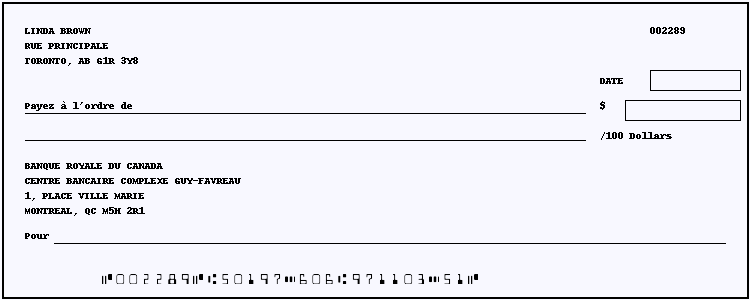

Inference time: 10.779170751571655
{'Client_Name': LINDA BROWN,'Bank_Name': ROYALE DU CANADA,'MICR_Data': 002289,'Bank_Name_Extract': ROYALE DU CANADA,'MICR_Data_Extract': 002289,'Client_Name_Extract': LINDA BROWN,'Bank_Name_Extract': ROYALE DU CANADA,'MICR_Data_Extract': 002289,'Bank


In [39]:
prompt_check = [{"role": "user", "content": "<|image_1|>\nExtract Client_Name, Bank_Name, MICR_Data in a JSON format"}]

i = random.randint(0, len(df_cheques) - 1)
# Download image from dataset
path_image = df_cheques.loc[i, 'file_name']

print(df_cheques.loc[i, 'client_name'])
print(df_cheques.loc[i, 'bank_name'])
print(df_cheques.loc[i, 'micr_code'])
# inference
model_inference(prompt_check, path_image, disp=True)

##Processus de finetuning
* Source : https://wandb.ai/byyoung3/mlnews3/reports/How-to-fine-tune-Phi-3-vision-on-a-custom-dataset--Vmlldzo4MTEzMTg3

In [32]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModelForCausalLM, AutoProcessor
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import pandas as pd
import random
import torch.nn.functional as F
import numpy as np
from torchvision.transforms.functional import resize, to_pil_image

#torch.manual_seed(3)

In [33]:
row = df_cheques.iloc[0]
user_prompt = "Extract Client_Name, Bank_Name, MICR_Data in a JSON format"
assistant_answer = f"{{'Client_Name': {row['client_name']},'Bank_Name': {row['bank_name']},'MICR_Data': {row['micr_code']}}}"
assistant_answer

"{'Client_Name': MARY JONES,'Bank_Name': CAISSE DESJARDINS DU COMPLEXE,'MICR_Data': 000001 24477 914 326115 48}"

In [34]:
# Custom Dataset
class MicrDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.tokenizer.padding_side = 'left'
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        user_prompt = "Extract Client_Name, Bank_Name, MICR_Data in a JSON format"
        assistant_answer = f"{{'Client_Name': {row['client_name']},'Bank_Name': {row['bank_name']},'MICR_Data': {row['micr_code']}}}"

        text = f"<|user|>\n<|image_1|>{user_prompt}<|end|><|assistant|>\n{assistant_answer}<|end|>"
        image_path = row['file_name']

        # Tokenize text
        encodings = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length)

        try:
            # Load and transform image
            image = Image.open(image_path).convert("RGB")
            image = self.image_transform_function(image)
        except (FileNotFoundError, IOError):
            # Skip the sample if the image is not found
            return None

        encodings['pixel_values'] = image

        return {key: torch.tensor(val) for key, val in encodings.items()}


    def image_transform_function(self, image):
        image = np.array(image)
        return image

In [35]:
df = df_cheques.copy()

# Initialize processor and tokenizer
#model_id = "microsoft/Phi-3-vision-128k-instruct"
#processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
tokenizer = processor.tokenizer


# Split dataset into training and validation sets
train_size = int(0.9 * len(df))
val_size = len(df) - train_size
train_indices, val_indices = random_split(range(len(df)), [train_size, val_size])
train_indices = train_indices.indices
val_indices = val_indices.indices
train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]


# Create dataset and dataloader
train_dataset = MicrDataset(train_df, tokenizer, max_length=512)
val_dataset = MicrDataset(val_df, tokenizer, max_length=512)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# Initialize model
#model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)


# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
# Training loop
num_epochs = 5
eval_interval = 150  # Evaluate every 'eval_interval' steps
loss_scaling_factor = 1000.0  # Variable to scale the loss by a certain amount
save_dir = './saved_models'
step = 0
accumulation_steps = 32  # Accumulate gradients over this many steps

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Select N item from the validation set for logging
num_log_samples = 2
log_indices = random.sample(range(len(val_dataset)), num_log_samples)

best_val_loss = float('inf')
best_model_path = None


In [36]:
def evaluate(model, val_loader, device, tokenizer, step, log_indices, max_samples=None, ):
    model.eval()
    total_loss = 0

    log_gt_texts = []
    log_pred_texts = []
    table = []

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if max_samples and i >= max_samples:
                break

            if batch is None:  # Skip if the batch is None
                continue

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = input_ids.clone().detach()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)

            #ground truth texts, and predicted texts
            if i in log_indices:
                log_gt_texts.append(tokenizer.decode(labels[0], skip_special_tokens=True))
                log_pred_texts.append(tokenizer.decode(predictions[0], skip_special_tokens=True))
                table.append([log_gt_texts[-1],log_pred_texts[-1]])

                # Log the table incrementally

    print({"Evaluation Results step {}".format(step): table, "Step": step})

    avg_loss = total_loss / (i + 1)  # i+1 to account for the loop index
    model.train()

    return avg_loss

In [37]:
#torch.cuda.empty_cache()

In [38]:
model.train()
for epoch in range(num_epochs):  # Number of epochs
    total_train_loss = 0
    batch_count = 0

    for batch in train_loader:
        step += 1

        if batch is None:  # Skip if the batch is None
            continue

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = input_ids.clone().detach()


        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss
        total_loss = loss
        predictions = torch.argmax(outputs.logits, dim=-1)

        total_loss.backward()

        if (step % accumulation_steps) == 0:
            for param in model.parameters():
                if param.grad is not None:
                    param.grad /= accumulation_steps
            optimizer.step()
            optimizer.zero_grad()

        total_train_loss += total_loss.item()
        batch_count += 1

        if step % 100 == 0:
          print(f"Epoch: {epoch}, Step: {step}, Batch Loss: {total_loss.item()}")


        if step % eval_interval == 0:
            val_loss = evaluate(model, val_loader, device, tokenizer=tokenizer, log_indices=log_indices, step=step )

            print(f"Step: {step}, Validation Loss: {val_loss}")


            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = os.path.join(save_dir, f"best_model")
                model.save_pretrained(best_model_path, safe_serialization=False)
                tokenizer.save_pretrained(best_model_path)

            avg_train_loss = total_train_loss / batch_count


    print(f"Epoch: {epoch}, Average Training Loss: {avg_train_loss}")

Epoch: 0, Step: 100, Batch Loss: 10.109962463378906
{'Evaluation Results step 150': [], 'Step': 150}
Step: 150, Validation Loss: 9.513894500732421
Epoch: 0, Step: 200, Batch Loss: 8.341936111450195
Epoch: 0, Step: 300, Batch Loss: 6.645449638366699
{'Evaluation Results step 300': [], 'Step': 300}
Step: 300, Validation Loss: 6.631702067057292
Epoch: 0, Step: 400, Batch Loss: 4.907678127288818
{'Evaluation Results step 450': [], 'Step': 450}
Step: 450, Validation Loss: 3.7856996981302897
Epoch: 0, Step: 500, Batch Loss: 3.2378711700439453
Epoch: 0, Step: 600, Batch Loss: 1.6518359184265137
{'Evaluation Results step 600': [], 'Step': 600}
Step: 600, Validation Loss: 1.6581169668833415
Epoch: 0, Average Training Loss: 6.7372356518109635
Epoch: 1, Step: 700, Batch Loss: 0.6032752394676208
{'Evaluation Results step 750': [], 'Step': 750}
Step: 750, Validation Loss: 0.31341540058453876
Epoch: 1, Step: 800, Batch Loss: 0.25444871187210083
Epoch: 1, Step: 900, Batch Loss: 0.1621963381767273
{'E